Gökçe Şahin 090190306 sahingo19@itu.edu.tr

# MAT 381E Homework 3

In [147]:
import requests
import regex as re
import tweepy as tw
import json
import matplotlib.pyplot as plt
import pandas as pd
import folium
import geopandas
import fsspec

from bs4 import BeautifulSoup
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from snowballstemmer import TurkishStemmer, EnglishStemmer
from collections import Counter
from wordcloud import WordCloud
from zipfile import ZipFile
from folium.plugins import HeatMap
from geopy.geocoders import Nominatim

from kaggle.api.kaggle_api_extended import KaggleApi
from folium.features import GeoJsonTooltip
from nltk.sentiment import SentimentIntensityAnalyzer

## Question 1

1. Using the library [Beautiful Soup](https://pypi.org/project/beautifulsoup4/) write a function that takes a URL from a specific Turkish Newspaper (any newspaper you'd like) and extracts and then returns the text (not the HTML source) of the news article given in the URL. (Warning: you cannot write a universal function that works for every newspaper. The function has to be specific to a specific newspaper.)

2. Write a separate function that cleans the text and removes all Turkish stopwords for a text coming from Step 1.

3. Display word clouds of 5 news articles after you apply the functions in Step 1 and Step 2.

In [148]:
# This function takes a URL from "Cumhuriyet" and returns the news article.

def get_text_Cumhuriyet(url):
    with requests.get(url) as link:
        raw = BeautifulSoup(link.content,'html.parser')

    text = raw.find('div', attrs={'class':"haberMetni"}).text

    return text

In [149]:
def clean_text(text):
    words = re.sub(r'[^\w\s]','',text.lower()).split()
    words_without_sw = [word for word in words if not word in stopwords.words('turkish')]
    cleaned_text = (' ').join(words_without_sw)
    
    return cleaned_text

In [150]:
def text_word_cloud(text):
    stemmer = TurkishStemmer()
    cleaned = stemmer.stemWords(text.split())

    plt.figure(figsize=(12,12))
    cloud = WordCloud(width = 1200, height = 600,
                    background_color ='white',
                    min_font_size = 10)
    plt.imshow(cloud.generate(' '.join(cleaned)))

In [151]:
news_links = ['https://www.cumhuriyet.com.tr/ekonomi/ecb-baskani-lagardedan-kripto-para-piyasalarina-iliskin-risk-uyarisi-2010160',
              'https://www.cumhuriyet.com.tr/dunya/time-dergisi-yilin-kahramanlarini-secti-iranli-kadinlar-2010148',
              'https://www.cumhuriyet.com.tr/dunya/bogaz-gecis-sirasi-bekleyen-tankerlere-yenileri-eklendi-2010033',
              'https://www.cumhuriyet.com.tr/turkiye/kirmizi-et-yemek-artik-hayal-olacak-ocak-ayi-icin-fiyat-verildi-2010211',
              'https://www.cumhuriyet.com.tr/dunya/rusyadan-ukrayna-mesaji-daha-fazla-bolgeyi-ilhak-etmeyecegiz-2010108']

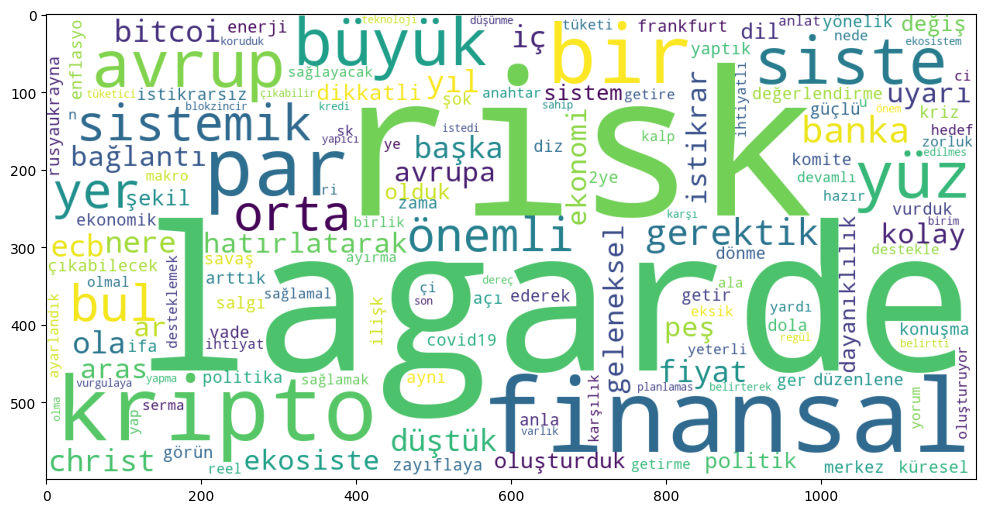

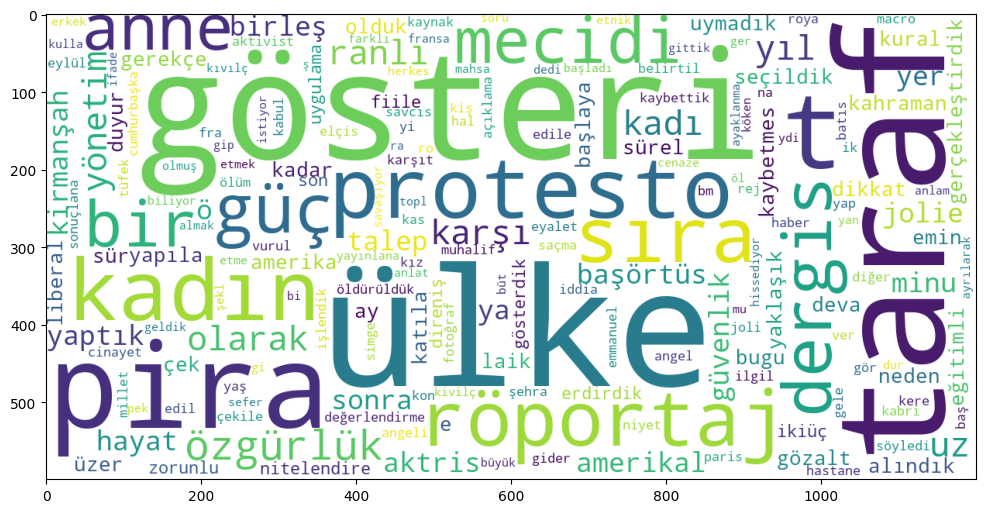

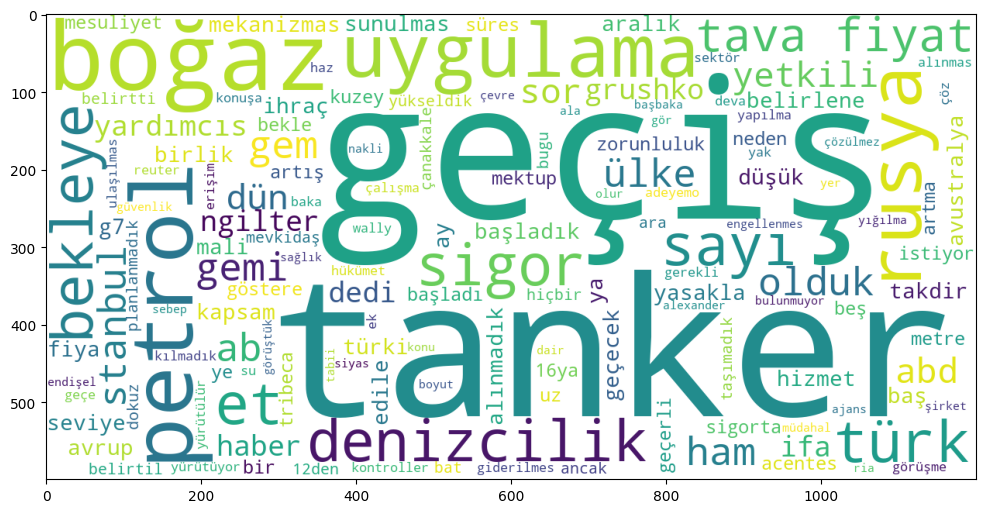

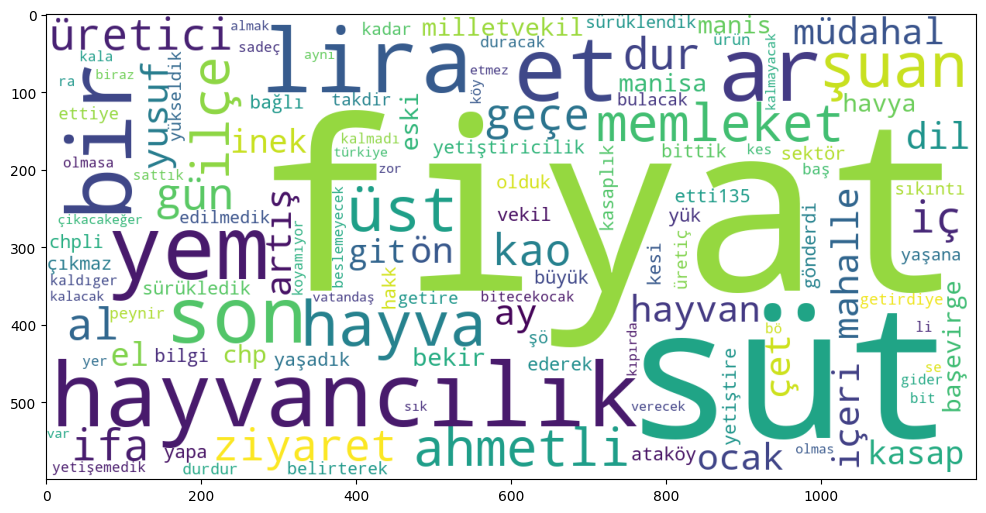

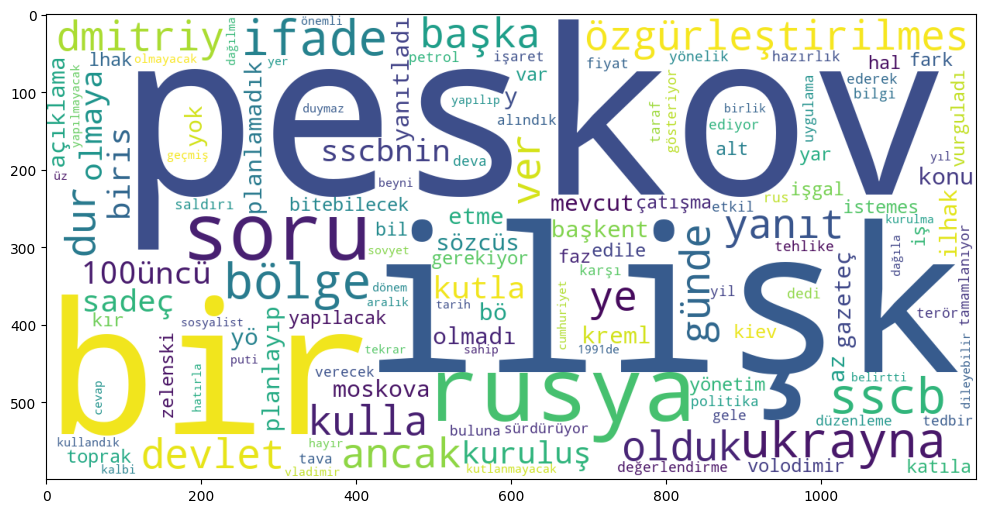

In [152]:
for link in news_links:
    news_text = get_text_Cumhuriyet(link)
    cleaned_text = clean_text(news_text)
    text_word_cloud(cleaned_text)

## Question 2

1. Using the library [tweepy](https://docs.tweepy.org/en/stable/index.html) pull 5000 tweets (in English) on any topic you'd like.

2. Clean the text and remove all stopwords. Then sketch a word cloud of your collection.

2. Using the library [NLTK](https://www.nltk.org/) apply sentiment analysis on the tweets you collected. 

3. Analyze your results.

In [153]:
with open('/Users/sahin/.config/twitter/twitter_apikey.json') as file:
    keys = json.load(file)

auth = tw.OAuth1UserHandler(
   keys["API_key"], keys["API_secret_key"], keys["access_token"], keys["access_secret"]
)

twitter_api = tw.API(auth)

In [154]:
# I couldn't pull 5000 tweets
raw_tweets = twitter_api.search_tweets(q='russia', lang='en', count=500)
tweets = [x.text for x in raw_tweets]

In [155]:
tweets_text = '. '.join(tweets)

words = re.sub(r'[^\w\s]','', tweets_text.lower()).split()
words_without_sw = [word for word in words if not word in stopwords.words('english')]
cleaned_tweets_text = (' ').join(words_without_sw)

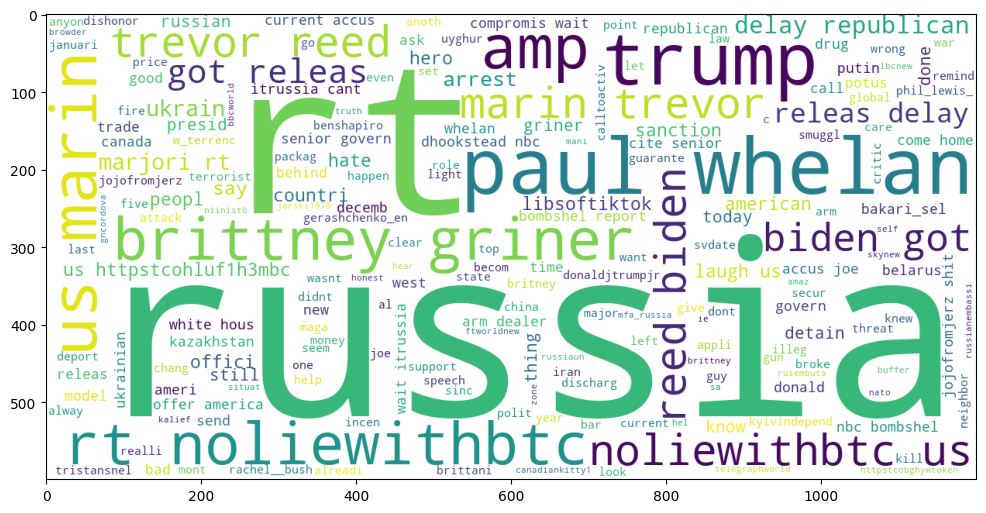

In [156]:
stemmer = EnglishStemmer()
cleaned = stemmer.stemWords(cleaned_tweets_text.split())

plt.figure(figsize=(12,12))
cloud = WordCloud(width = 1200, height = 600,
                background_color ='white',
                min_font_size = 10)
plt.imshow(cloud.generate(' '.join(cleaned)))

In [157]:
sia = SentimentIntensityAnalyzer()
sentences = sent_tokenize(tweets_text)

res = []
for sentence in sentences:
    row = {'sentence': sentence}
    row.update(sia.polarity_scores(sentence))
    res.append(row)
    
pd.DataFrame(res)

sentence    neg    neu    pos  \
0    @RussianEmbassy @mfa_russia @RussiaUN @RusEmbU...  0.000  1.000  0.000   
1    RT @GNCordova: Too many Americans only care ab...  0.000  0.849  0.151   
2                             Kalief Browder was hel….  0.000  1.000  0.000   
3     RT @Jarski1979: @Gerashchenko_en Amazing speech.  0.000  0.513  0.487   
4    So good to hear honest truth of the situation ...  0.000  0.577  0.423   
..                                                 ...    ...    ...    ...   
148  RT @Phil_Lewis_: For those who were curious ab...  0.083  0.827  0.091   
149    @thezambologist @RALee85 😂😂😂 Well Done #Russia.  0.000  0.704  0.296   
150  Kremlin sets out response to West's oil price ...  0.254  0.746  0.000   
151  RT @peltzmadeline: The right-wing media has be...  0.286  0.714  0.000   
152                                      Deferring to…  0.630  0.370  0.000   

     compound  
0      0.0000  
1      0.4939  
2      0.0000  
3      0.5859  
4      0.8313  
..        ...  
148    0.0516  
149    0.2732  
150   -0.7783  
151   -0.7783  
152   -0.1779  

[153 rows x 5 columns]

## Question 3

For this question use [UFO Sightings Dataset](https://www.kaggle.com/code/hakeemtfrank/ufo-sightings-data-exploration/data) from Kaggle.

1. Ingest the dataset as a pandas dataframe, and clean it if necessary.

2. Plot a geographic heatmap of UFO sightings and find hotspots.

3. Is there a statistically verifiable correlation between shape of the UFO and the duration of the sighting. Investigate.

In [158]:
# I couldn't get the data with this code so I downloaded it.

# kaggle_api = KaggleApi()
# kaggle_api.authenticate()

# kaggle_api.dataset_download_files('hakeemtfrank/ufo-sightings-data-exploration', 
#                            path='/data')
# zip = ZipFile('/data/ufo-sightings-data-exploration.zip')

# data = pd.read_csv(zip.open('complete.csv'))
# zip.close()
# data

In [159]:
ufo_sightings_data = pd.read_csv('./data/scrubbed.csv')

C:\Users\sahin\AppData\Local\Temp\ipykernel_3912\2472128867.py:1: DtypeWarning: Columns (5,9) have mixed types. Specify dtype option on import or set low_memory=False.
  ufo_sightings_data = pd.read_csv('./data/scrubbed.csv')


In [160]:
# clean data
ufo_sightings_data = ufo_sightings_data.rename(columns = {"longitude ":"longitude"})
ufo_sightings_data['latitude'] = ufo_sightings_data['latitude'].str.replace(r'[^\d.]+', '')
ufo_sightings_data['latitude'] = ufo_sightings_data['latitude'].astype(float)               # Convert column to integer

C:\Users\sahin\AppData\Local\Temp\ipykernel_3912\894892464.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  ufo_sightings_data['latitude'] = ufo_sightings_data['latitude'].str.replace(r'[^\d.]+', '')


In [161]:
map_obj = folium.Map()

lats_longs = ufo_sightings_data[['latitude', 'longitude']].dropna().to_numpy()

HeatMap(lats_longs).add_to(map_obj)

map_obj

In [163]:
ufo_sightings_data.groupby('city').count().sort_values('datetime', ascending = False)

datetime  state  country  shape  duration (seconds)  \
city                                                                            
seattle                        525    525      524    473                 525   
phoenix                        454    454      454    438                 454   
portland                       374    374      373    355                 374   
las vegas                      368    368      367    357                 368   
los angeles                    353    353      352    348                 353   
...                            ...    ...      ...    ...                 ...   
indianapolis (southeast)         1      1        1      1                   1   
indianapolis speedway            1      1        0      1                   1   
indianpolis                      1      1        0      1                   1   
indio and san diego              1      1        0      1                   1   
zwolle                           1      1        1      1                   1   

                          duration (hours/min)  comments  date posted  \
city                                                                    
seattle                                    525       524          525   
phoenix                                    454       454          454   
portland                                   374       374          374   
las vegas                                  368       368          368   
los angeles                                353       353          353   
...                                        ...       ...          ...   
indianapolis (southeast)                     1         1            1   
indianapolis speedway                        1         1            1   
indianpolis                                  1         1            1   
indio and san diego                          1         1            1   
zwolle                                       1         1            1   

                          latitude  longitude  
city                                           
seattle                        436        525  
phoenix                        397        454  
portland                       294        374  
las vegas                      303        368  
los angeles                    299        353  
...                            ...        ...  
indianapolis (southeast)         1          1  
indianapolis speedway            1          1  
indianpolis                      1          1  
indio and san diego              0          1  
zwolle                           1          1  

[19900 rows x 10 columns]

## Question 4

For this question use [Turkish Institute of Statistics (TÜİK)](https://data.tuik.gov.tr/) data portal, and [The Humanitarian Data Exchange (HDX)](https://www.eea.europa.eu/data-and-maps/data/) data portal.

1. Get the population data for cities in Turkey as a pandas data frame from TUIK. Notice that TUIK generates the data only for human consumption. Clean the data and get well-defined columns and rows that contain only the data removing all unnecessary metadata (keep the column names). Cleaning must be done using python only. You are NOT allowed to clean it externally.

2. Get the crime statistics (Suçun İşlendiği İl ve Suç Türüne Göre Ceza İnfaz Kurumundan Çıkan Hükümlüler) as a pandas data frame from TUIK. Clean the data and get well-defined columns and rows that contain only the data removing all unnecessary metadata (keep the column names). Cleaning must be done python only. You are NOT allowed to clean it externally.

3. Get the shape files for the Turkish city municipality borders from HDX, ingest it as a geoPandas datafroma, and then clean it if necessary. Cleaning must be done using python only. You are NOT allowed to clean it externally.

4. Merge the population data, crime data, and the shapefile data into a single geoPandas dataframe.

5. Plot the population data as a choropleth map as I did in the class.

6. Plot the crime data for different categories. However, don't use the raw numbers. Use the normalized data with respect to the population of the city.

In [164]:
turkey_population = pd.read_excel('https://data.tuik.gov.tr/Bulten/DownloadIstatistikselTablo?p=GrlF0IAU/X4TAAB72KN91wNk2qeGX5ZKuW4dVxaXMb6S2joaMc/YMTSsc4eCFeg/')

city_population = turkey_population.iloc[4:85]

col_names = ['city']
[col_names.append(str(year)) for year in range(2000,2022)]
city_population.columns = col_names


In [193]:
turkey_crime= pd.read_excel('https://data.tuik.gov.tr/Bulten/DownloadIstatistikselTablo?p=0c5KfxXInUNA2cwmM5wEjdHXHy4lfdZY/pxlFAQ/LPVYyd6qyrq4Nyf/kIOYH/xt')

In [194]:
turkey_crime = turkey_crime.rename(columns = {"Unnamed: 1":"city"})

In [199]:
turkey_crime.dropna().iloc[1:].groupby('city').sum()

C:\Users\sahin\AppData\Local\Temp\ipykernel_3912\1102796453.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  turkey_crime.dropna().iloc[1:].groupby('city').sum()


İBBS 3. Düzeyde, suçun işlendiği il ve suç türüne göre ceza infaz kurumundan çıkan hükümlüler, 2011-2020  \
city                                                                                                                        
Adana                                          TR621TR621TR621TR621                                                         
Adıyaman                                       TRC12TRC12TRC12TRC12                                                         
Afyonkarahisar                                 TR332TR332TR332TR332                                                         
Aksaray                                        TR712TR712TR712TR712                                                         
Amasya                                         TR834TR834TR834TR834                                                         
...                                                             ...                                                         
Çorum                                          TR833TR833TR833TR833                                                         
İstanbul                                       TR100TR100TR100TR100                                                         
İzmir                                          TR310TR310TR310TR310                                                         
Şanlıurfa                                      TRC21TRC21TRC21TRC21                                                         
Şırnak                                         TRC33TRC33TRC33TRC33                                                         

                                                        Unnamed: 2  \
city                                                                 
Adana             Erkek - MaleErkek - MaleErkek - MaleErkek - Male   
Adıyaman          Erkek - MaleErkek - MaleErkek - MaleErkek - Male   
Afyonkarahisar    Erkek - MaleErkek - MaleErkek - MaleErkek - Male   
Aksaray           Erkek - MaleErkek - MaleErkek - MaleErkek - Male   
Amasya            Erkek - MaleErkek - MaleErkek - MaleErkek - Male   
...                                                            ...   
Çorum             Erkek - MaleErkek - MaleErkek - MaleErkek - Male   
İstanbul          Erkek - MaleErkek - MaleErkek - MaleErkek - Male   
İzmir             Erkek - MaleErkek - MaleErkek - MaleErkek - Male   
Şanlıurfa         Erkek - MaleErkek - MaleErkek - MaleErkek - Male   
Şırnak            Erkek - MaleErkek - MaleErkek - MaleErkek - Male   

                  Unnamed: 3  Unnamed: 4  Unnamed: 5  Unnamed: 6  Unnamed: 9  \
city                                                                           
Adana                  37000         936        4697         434        7058   
Adıyaman                3983         139         573          42         745   
Afyonkarahisar         10934         339        1924         234        1437   
Aksaray                 5111         130         985          80         747   
Amasya                  4934         104         900          87         485   
...                      ...         ...         ...         ...         ...   
Çorum                   6055         205        1037         126         784   
İstanbul              165486        3487       20679        2552       29718   
İzmir                  80604        1382       10264        1055       13088   
Şanlıurfa              14883         339        1810         135        3446   
Şırnak                  4049          64         230          22         433   

                  Unnamed: 12  Unnamed: 13  Unnamed: 18  Unnamed: 19  \
city                                                                   
Adana                    2948         1733         1639         1168   
Adıyaman                  288          260           74          116   
Afyonkarahisar            176          230          210          457   
Aksaray                   242          332          183          214   
Amasya 

In [166]:
city_population = turkey_population.iloc[4:85]

col_names = ['city']
[col_names.append(str(year)) for year in range(2000,2022)]
city_population.columns = col_names

In [ ]:
turkey_crime = pd.read_excel('https://data.tuik.gov.tr/Bulten/DownloadIstatistikselTablo?p=GrlF0IAU/X4TAAB72KN91wNk2qeGX5ZKuW4dVxaXMb6S2joaMc/YMTSsc4eCFeg/')


In [167]:
# I couldn't download geoplot library :(

In [168]:
link = 'https://data.humdata.org/dataset/ac768a5c-db29-4872-9792-bd3179e29c45/resource/8d052597-b24c-4bd8-a24e-81a3a4ff21ac/download/tur_adm_2022_wgs_84.gdb.zip'

with fsspec.open(link) as file:
    df = geopandas.read_file(file)

ImportError: HTTPFileSystem requires "requests" and "aiohttp" to be installed